# Notebook to access and analyze results

### Imports

In [1]:
# starting kernel

%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
pd.options.display.max_columns = None
from pandas_ply import install_ply, X, sym_call
install_ply(pd)
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

def print_df(df):
    display(df)
    return df

from pathlib import Path
FIG_OUT_DIR = Path('Results')

In [2]:
# Debugger: After seeing an exception, uncomment and run the following
# import pdb; pdb.pm()

In [3]:
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf

from support.database.records_aggregator import MongoAggregator
from support.database.mongo import get_table

import pickle
from copy import copy

from tqdm import tqdm

# I- Paper results

## I-1- Load data

In [ ]:
## Load results

if 'hydra_initialized' not in locals():
    initialize(config_path="config")
    hydra_initialized = True
cfg = compose("config.yaml", overrides=[])
print(cfg)

run_switch = dict(
    sachs = True,
    gss = True,
    auto_mpg = True,
    red_wine = True,
    white_wine = True,
    boston_housing = True,
)

In [ ]:
## Get records

remote = True
remote_port = 27015
use_dumped_records = True


if use_dumped_records:
    def get_records_from_dump(table_name=None):
        import bson
        with open(Path('Records/mongodump') / f'20210105121154_mongodump_{table_name}/causal-data-augmentation/{table_name}.bson', 'rb') as f:
            data = pd.DataFrame(bson.decode_all(f.read()))
        return data
    get_records = get_records_from_dump
else:
    def get_records_from_mongo(table_name=None):
        all_records_uai = MongoAggregator(
            get_table(cfg.recording.table_name if table_name is None else table_name, cfg.database.mongo_host,
                      cfg.database.mongo_port if not remote else remote_port, cfg.database.mongo_user,
                      cfg.database.mongo_pass, cfg.database.mongo_dbname),
            query={}).get_results_pd(index=None)
        return all_records_uai
    get_records = get_records_from_mongo


all_records_uai = {}
for data_name, run in run_switch.items():
    if not run:
        continue
    all_records_uai.update({data_name: get_records(f'main_{data_name}')})

## I-2- Get UAI expe params

In [ ]:
# chose a specific experiement of interest
exp_res_uai = all_records_uai['red_wine']

# basic info
print("Selected experiment: " + exp_res_uai.data.unique()[0])
print(' ')
print("Number of trainings: " + str(exp_res_uai.train_size.nunique()))
print("Number of replicates per training: " + str(exp_res_uai.data_run_id.nunique()))
print(' ')
print("Preprocessing parameters: " + exp_res_uai.preprocessing.astype(str).unique()[0])
print(' ')
print("XGB parameters: " + exp_res_uai.method_predictor.astype(str).unique()[0])
print(' ')
print("Augmenter name: " + exp_res_uai[exp_res_uai['method_name']=='proposed'].method_augmenter_config_name.unique()[0])
print("Augmenter parameters: " + exp_res_uai[exp_res_uai['method_name']=='proposed'].method_augmenter_config.astype(str).unique()[0])
print("Method fit to augmented data only: " + str(exp_res_uai[exp_res_uai['method_name']=='proposed'].method_fit_to_aug_only.unique()[0]))
print("Method augmentation coefficient : " + str(exp_res_uai[exp_res_uai['method_name']=='proposed'].method_aug_coeff.astype(str).unique()[0]))
#print("Augmenter weight threshold: " + str(exp_res_uai[exp_res_uai['method_name']=='proposed'].augmenter_config_weight_threshold.unique()[0]))
print("Validation run: " + str(exp_res_uai[exp_res_uai['method_name']=='proposed'].validation_run.unique()[0]))
print(' ')

In [ ]:
# train val and test settings 
exp_res_uai_train_val_test = exp_res_uai[["train_size", "validation_size", "test_size"]].drop_duplicates()
exp_res_uai_train_val_test['total_size'] = exp_res_uai_train_val_test["train_size"] + exp_res_uai_train_val_test["validation_size"] + exp_res_uai_train_val_test["test_size"]
exp_res_uai_train_val_test['(train+val)/total'] = np.round(100*(exp_res_uai_train_val_test["train_size"]+exp_res_uai_train_val_test["validation_size"]) / exp_res_uai_train_val_test["total_size"])
exp_res_uai_train_val_test['test/total'] = np.round(100*exp_res_uai_train_val_test["test_size"] / exp_res_uai_train_val_test["total_size"])
exp_res_uai_train_val_test['val/train'] = np.round(100*exp_res_uai_train_val_test["validation_size"] / exp_res_uai_train_val_test["train_size"])
exp_res_uai_train_val_test

In [ ]:
# n_both : les samples qui appartiennent au jeu d'entrainement et aux données augmentées
# n_aug_only : les samples qui n'appartiennent qu'aux données augmentées
# n_orig_only : les samples qui n'appartiennent qu'au jeu d'entrainement --> Ces samples ne sont pas gardés après augmentation
# augmented_size = n_aug_only + n_both
(exp_res_uai["n_aug_only"] + exp_res_uai["n_both"] - exp_res_uai["augmented_size"]).unique()

In [ ]:
# augmented_size = train_size + validation_size - n_orig_only
(exp_res_uai["train_size"] + exp_res_uai["validation_size"] - exp_res_uai["n_orig_only"] - exp_res_uai["augmented_size"]).unique()

In [ ]:
# However, I don't know what's n_both
# it is not train_size + validation_size, nor train_size only

In [ ]:
exp_res_uai.head()

## I-3- Plot paper results

### I-3-a- Preprocessing

In [ ]:
from support.pandas_support import conditional_where, conditional_mutate

PROP = (X.method == 'proposed')

records = {}
for data_name, run in run_switch.items():
    if not run:
        continue
    _records = all_records_uai[data_name].reset_index().copy()

    namer = lambda x: f"{x['method']}"
    _records = conditional_mutate(_records, PROP, lambda _rec: _rec.ply_select('*', method=_rec.apply(namer, axis=1)))

    records.update({data_name: _records})

### I-3-b- MSE proposed VS baseline

In [ ]:
from itertools import cycle

METHOD_LABELS = {
    'base_xgb': 'Baseline',
    'proposed': 'Proposed'
}

XLABEL = 'Train data size'
YLABEL = 'MSE'

plt.rc('font', **{
    'family': 'Times New Roman',
    'weight' : 'normal',
    'size'   : 16})

monochrome = False

for data_name, run in run_switch.items():
    if not run:
        continue
    printmd(f'# {data_name}')
    _records = records[data_name]

    fig, ax = plt.subplots(figsize=(8,6))
    if monochrome:
        colors = cycle(['k'])
    else:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    linestyles = cycle(['--', '-', '-.', ':'])
    markers = cycle(['o', '*', '^', 's', 'X'])

    plot_df = (_records
     .groupby(['method', 'data', 'train_size'])
     .ply_select(average = X.XGB_MSE.mean(), err_min = X.XGB_MSE.mean()-X.XGB_MSE.sem(ddof=0), err_max = X.XGB_MSE.mean()+X.XGB_MSE.sem(ddof=0))
     .reset_index()
    )

    for ((_method, _data), _df), color, linestyle, marker in zip(plot_df.groupby(['method', 'data']), colors, linestyles, markers):
        kind = 'line'
        ax = plt.gca()
        markersize = 8 if marker not in ['*'] else 10
        _df.plot('train_size', 'average', kind=kind, ax=ax, label=METHOD_LABELS[_method],
                 c=color, marker=marker, linestyle=linestyle, markersize=markersize)
        ax.fill_between(_df['train_size'], _df['err_min'], _df['err_max'], alpha=0.2, facecolor=color)
        plt.xlabel(XLABEL)
        plt.ylabel(YLABEL)
    plt.legend()

    #plt.savefig(FIG_OUT_DIR / f'{data_name}{"_mono" if monochrome else ""}.pdf')
    plt.show()
    plt.clf()

### I-3-c- Percentage evol of MSE proposed VS baseline

In [ ]:
metric = 'XGB_MSE'
BASELINE_NAME = 'base_xgb'
#TITLE = 'Average relative improvement $\\left(\\frac{aug - orig}{orig} \\times 100\\right)$ %'
TITLE = ''

for data_name, run in run_switch.items():
    if not run:
        continue
    printmd(f'# {data_name}')
    _records = records[data_name]

    all_methods = list(_records.method.unique())

    for method in (set(all_methods)-set([BASELINE_NAME])):
        methods = [BASELINE_NAME, method]
        color = 'k'
        _df = (_records.ply_where(X.method.isin(methods)).sort_values('method').pivot_table(index=['train_size', 'data_run_id'], columns='method_name', values=[metric])
         .pct_change(axis=1).iloc[:, -1].mul(100) # Compute change in %
         .unstack()
        )
        ax = plt.gca()
        _df['err_min'] = _df.mean(axis=1) - _df.sem(axis=1, ddof=0)
        _df['err_max'] = _df.mean(axis=1) + _df.sem(axis=1, ddof=0)
        _df.mean(axis=1).plot(title=TITLE, ax=ax, marker='o', color=color, markersize=8)
        ax.fill_between(_df.index, _df['err_min'], _df['err_max'], alpha=0.2, facecolor=color)

        #plt.savefig(FIG_OUT_DIR / f'relative_improvement_{data_name}_{method}.pdf')
        plt.show()
        plt.clf()

# II- Audrey's results

## II-1- Load files

### II-1-a- Loading MongoDB database

In [13]:
## Load results

if 'hydra_initialized' not in locals():
    initialize(config_path="config")
    hydra_initialized = True
cfg = compose("config.yaml", overrides=[])
print(cfg)

run_switch_me = dict(
    sachs = True,
    gss = False,
    auto_mpg = False,
    red_wine = True,
    white_wine = False,
    boston_housing = False,
)

{'data': {'data': {'name': 'sachs_obs', 'module': 'sachs', 'train_size': 0.3, 'data_path': 'data/sachs/main.result.ourvarrs/1. cd3cd28.txt', 'graph': {'path': 'data/sachs/sachs.bif', 'loader': 'load_consensus_graph'}, 'preprocess': [{'log_transform': ['Raf', 'Mek', 'PKA']}, {'normalize': True}]}, 'validation_size': 0, 'train_size': 0}, 'method': {'method': {'name': 'proposed', 'fit_to_aug_only': False, 'augmenter_config_name': 'FullAugment', 'augmenter_config': {'normalize_threshold_by_data_size': True, 'weight_threshold': 0.001, 'weight_threshold_type': 'total', 'weight_kernel_cfg': {'type': 'vanilla_kernel', 'conti_kertype': 'gaussian', 'conti_bw_method': 'normal_reference', 'conti_bw_temperature': 1, 'ordered_kertype': 'indicator', 'ordered_bw_method': 'indicator', 'unordered_kertype': 'indicator', 'unordered_bw_method': 'indicator', 'const_bandwidth': False, 'bandwidth_temperature': 0.001}}, 'aug_coeff': [0.5]}, 'predictor': {'method': {'predictor': {'n_estimators': [10, 50, 250, 1

c:\Users\AudreyPOINSOT\anaconda3\envs\ADMGresults\lib\site-packages\hydra\experimental\compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)
c:\Users\AudreyPOINSOT\anaconda3\envs\ADMGresults\lib\site-packages\hydra\_internal\defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [5]:
## Get records

remote = False
remote_port = 27015
use_dumped_records = False

if use_dumped_records:
    def get_records_from_dump(table_name=None):
        import bson
        with open(Path('Records/mongodump') / f'20210105121154_mongodump_{table_name}/causal-data-augmentation/{table_name}.bson', 'rb') as f:
            data = pd.DataFrame(bson.decode_all(f.read()))
        return data
    get_records = get_records_from_dump
else:
    def get_records_from_mongo(table_name=None):
        all_records = MongoAggregator(
            get_table(cfg.recording.table_name if table_name is None else table_name, cfg.database.mongo_host,
                      cfg.database.mongo_port if not remote else remote_port, cfg.database.mongo_user,
                      cfg.database.mongo_pass, cfg.database.mongo_dbname),
            query={}).get_results_pd(index=None)
        return all_records
    get_records = get_records_from_mongo


all_records = {}
for data_name, run in run_switch_me.items():
    if not run:
        continue
    all_records.update({data_name: get_records(f'main_{data_name}')})

#### Visualize loaded data and get/verify expe params

In [6]:
# chose a specific experiement of interest
exp_res_me = all_records['sachs']

# basic info
print("Selected experiment: " + exp_res_me.data.unique()[0])
print(' ')
print("Number of trainings: " + str(exp_res_me.train_size.nunique()))
print("Number of replicates per training: " + str(exp_res_me.data_run_id.nunique()))
print(' ')
print("Preprocessing parameters: " + exp_res_me.preprocessing.astype(str).unique()[0])
print(' ')
print("XGB parameters: " + exp_res_me.method_predictor.astype(str).unique()[0])
print(' ')
print("Augmenter name: " + exp_res_me[exp_res_me['method_name']=='proposed'].method_augmenter_config_name.unique()[0])
print("Augmenter parameters: " + exp_res_me[exp_res_me['method_name']=='proposed'].method_augmenter_config.astype(str).unique()[0])
print("Method fit to augmented data only: " + str(exp_res_me[exp_res_me['method_name']=='proposed'].method_fit_to_aug_only.unique()[0]))
print("Method augmentation coefficient : " + str(exp_res_me[exp_res_me['method_name']=='proposed'].method_aug_coeff.astype(str).unique()[0]))
#print("Augmenter weight threshold: " + str(exp_res_me[exp_res_me['method_name']=='proposed'].augmenter_config_weight_threshold.unique()[0]))
print("Validation run: " + str(exp_res_me[exp_res_me['method_name']=='proposed'].validation_run.unique()[0]))
print(' ')

Selected experiment: sachs_obs
 
Number of trainings: 29
Number of replicates per training: 20
 
Preprocessing parameters: [{'log_transform': ['Raf', 'Mek', 'PKA']}, {'normalize': True}]
 
XGB parameters: {'n_estimators': [10, 50, 250, 1250], 'reg_lambda': [1, 10, 100, 1000]}
 
Augmenter name: FullAugment
Augmenter parameters: {'normalize_threshold_by_data_size': True, 'weight_threshold': 0.001, 'weight_threshold_type': 'total', 'weight_kernel_cfg': {'type': 'vanilla_kernel', 'conti_kertype': 'vanilla_kernel', 'const_bandwidth': False, 'bandwidth_temperature': 0.001}}
Method fit to augmented data only: False
Method augmentation coefficient : [0.5]
Validation run: False
 


In [8]:
exp_res_me[exp_res_me['method']=='proposed'].head()

_id  sacred_run_id  recording_set    method  \
12  63623b287a35dd747011d4e9            341              1  proposed   
14  63623b633d2fc0d4265a8e47            343              1  proposed   
16  63623b9f249bfd2c3eb909ab            345              1  proposed   
18  63623bd435f53025004bbfe6            347              1  proposed   
20  63623c10c5928e47e881f05e            349              1  proposed   

         data data_module                                          data_path  \
12  sachs_obs       sachs  /mnt/c/git/Causal Data Augmentation/ADMG/exper...   
14  sachs_obs       sachs  /mnt/c/git/Causal Data Augmentation/ADMG/exper...   
16  sachs_obs       sachs  /mnt/c/git/Causal Data Augmentation/ADMG/exper...   
18  sachs_obs       sachs  /mnt/c/git/Causal Data Augmentation/ADMG/exper...   
20  sachs_obs       sachs  /mnt/c/git/Causal Data Augmentation/ADMG/exper...   

   data_run_id                                        data_config  \
12     sachs_1  {'name': 'sachs_obs', 'module': 'sachs', 'trai...   
14     sachs_2  {'name': 'sachs_obs', 'module': 'sachs', 'trai...   
16     sachs_3  {'name': 'sachs_obs', 'module': 'sachs', 'trai...   
18     sachs_4  {'name': 'sachs_obs', 'module': 'sachs', 'trai...   
20     sachs_5  {'name': 'sachs_obs', 'module': 'sachs', 'trai...   

                                        preprocessing  \
12  [{'log_transform': ['Raf', 'Mek', 'PKA']}, {'n...   
14  [{'log_transform': ['Raf', 'Mek', 'PKA']}, {'n...   
16  [{'log_transform': ['Raf', 'Mek', 'PKA']}, {'n...   
18  [{'log_transform': ['Raf', 'Mek', 'PKA']}, {'n...   
20  [{'log_transform': ['Raf', 'Mek', 'PKA']}, {'n...   

                                      data_cache_name  \
12  sachs_obs_log_transform_['Raf', 'Mek', 'PKA']_...   
14  sachs_obs_log_transform_['Raf', 'Mek', 'PKA']_...   
16  sachs_obs_log_transform_['Raf', 'Mek', 'PKA']_...   
18  sachs_obs_log_transform_['Raf', 'Mek', 'PKA']_...   
20  sachs_obs_log_transform_['Raf', 'Mek', 'PKA']_...   

                                      data_cache_path  \
12  /mnt/c/git/Causal Data Augmentation/ADMG/exper...   
14  /mnt/c/git/Causal Data Augmentation/ADMG/exper...   
16  /mnt/c/git/Causal Data Augmentation/ADMG/exper...   
18  /mnt/c/git/Causal Data Augmentation/ADMG/exper...   
20  /mnt/c/git/Causal Data Augmentation/ADMG/exper...   

                                           graph_path          graph_loader  \
12  /mnt/c/git/Causal Data Augmentation/ADMG/exper...  load_consensus_graph   
14  /mnt/c/git/Causal Data Augmentation/ADMG/exper...  load_consensus_graph   
16  /mnt/c/git/Causal Data Augmentation/ADMG/exper...  load_consensus_graph   
18  /mnt/c/git/Causal Data Augmentation/ADMG/exper...  load_consensus_graph   
20  /mnt/c/git/Causal Data Augmentation/ADMG/exper...  load_consensus_graph   

    train_size  test_size method_name  \
12        1119       6347    proposed   
14        1119       6347    proposed   
16        1119       6347    proposed   
18        1119       6347    proposed   
20        1119       6347    proposed   

                                     method_predictor exp_wide_artifacts  \
12  {'n_estimators': [10, 50, 250, 1250], 'reg_lam...                 []   
14  {'n_estimators': [10, 50, 250, 1250], 'reg_lam...                 []   
16  {'n_estimators': [10, 50, 250, 1250], 'reg_lam...                 []   
18  {'n_estimators': [10, 50, 250, 1250], 'reg_lam...                 []   
20  {'n_estimators': [10, 50, 250, 1250], 'reg_lam...                 []   

     XGB_MSE finished method_fit_to_aug_only method_augmenter_config_name  \
12  0.276820     True                  False                  FullAugment   
14  0.284499     True                  False                  FullAugment   
16  0.263103     True                  False                  FullAugment   
18  0.277053     True                  False                  FullAugment   
20  0.276077     True                  False                  FullAugment   

                         

In [ ]:
#exp_res_me[(exp_res_me['sacred_run_id']>=1627)&(exp_res_me['method']=='proposed')].tail()
exp_res_me[(exp_res_me['sacred_run_id']>=1627)&(exp_res_me['method']=='proposed')&(exp_res_me['n_aug_only']>0)].head()

In [ ]:
# is sacred_run_id a unique identifier? --> YES
exp_res_me.shape[0] == exp_res_me.sacred_run_id.nunique()

### II-1-b- Loading dill files

#### II-1-b-i Dill files of ONE EXP

In [ ]:
# Load dill files for ONE EXP

selected_dataset = "sachs_obs"
selected_exp = "_log_transform_['Raf', 'Mek', 'PKA']_normalize_True_sachs_8_ts0.03_run1" # sachs_2_ts0.01_run1
selected_exp_all = "_log_transform_['Raf', 'Mek', 'PKA']_normalize_True"

file_to_open = selected_dataset + selected_exp + "_"
path_to_res = "pickle/data/" + selected_dataset + "/"

path_file_to_aug = Path(path_to_res + file_to_open + "augmented.dill")
path_file_to_pruned = Path(path_to_res + file_to_open + "pruned.dill")
path_file_to_data = Path(path_to_res + file_to_open + "data.dill")
path_file_to_indices = Path(path_to_res + "indices/" + file_to_open + "indices.dill")
path_file_to_fulldata = Path(path_to_res + "fulldata_" + selected_dataset + selected_exp_all + ".dill")

if path_file_to_data.exists():
    with path_file_to_data.open('rb') as _f:
        train_df, test_df = pickle.load(_f) # train and test set used for this specific run
else:
    print("Unknown file : " + str(path_file_to_data))
    
if path_file_to_pruned.exists():
    with path_file_to_pruned.open('rb') as _f:
        pruned_df = pickle.load(_f) # train and test set used for this specific run
else:
    print("Unknown file : " + str(path_file_to_pruned))

if path_file_to_aug.exists():
    with path_file_to_aug.open('rb') as _f:
        aug_df = pickle.load(_f) # train and test set used for this specific run
else:
    print("Unknown file : " + str(path_file_to_aug))

if path_file_to_indices.exists():
    with path_file_to_indices.open('rb') as _f:
        ind0, ind1 = pickle.load(_f) # indices of the train and test data used for this specific run --> to reduce memory usage
else:
    print("Unknown file : " + str(path_file_to_indices))

if path_file_to_fulldata.exists():
    with path_file_to_fulldata.open('rb') as _f:
        fulldata = pickle.load(_f) # the full dataset of the experiment
else:
    print("Unknown file : " + str(path_file_to_fulldata))

In [ ]:
# tailles des jeux de données
print("train size", train_df.shape)
print("test size", test_df.shape)
print("aug size", aug_df.shape)
print("pruned size", pruned_df.shape)

In [ ]:
# caractéristiques des données augmentées

normalized_threshold = True
threshold = 0.001

if normalized_threshold:
    threshold = threshold/len(train_df)
    print("normalized_threshold", threshold)
print("")
print("nombre de données augmentées avec un poids inférieur au seuil", aug_df[aug_df['aug_weights']<threshold].shape[0])
print("en proportion", 100*aug_df[aug_df['aug_weights']<threshold].shape[0]/aug_df.shape[0])
print("Quelques exemples")
aug_df[aug_df['aug_weights']<threshold].head()

In [ ]:
# exemples générés appartenant au jeu de train
aug_df_merge = aug_df.copy()
aug_df_merge['aug_sample'] = 1
train_df_join_aug = train_df.merge(aug_df_merge, how="left", on=list(train_df.columns))
print("nombre de exemples générés appartenant au jeu de train ", train_df_join_aug.dropna().shape[0])
print("Quelques exemples")
train_df_join_aug.dropna().head()

In [ ]:
# données filtrées du jeu de train
print("nombre de données filtrées ", train_df_join_aug[train_df_join_aug['aug_sample'].isna()].shape[0])
print("Quelques exemples")
train_df_join_aug[train_df_join_aug['aug_sample'].isna()].head()

In [ ]:
# nouveaux exemples générés
train_df_merge = train_df.copy()
train_df_merge['train_sample'] = 1
aug_df_join_train = aug_df.merge(train_df_merge, how="left", on=list(train_df.columns))
print("nombre de nouveaux exemples générés ", aug_df_join_train[aug_df_join_train['train_sample'].isna()].shape[0])
print("Quelques exemples")
aug_df_join_train[aug_df_join_train['train_sample'].isna()].head()

In [ ]:
# visualisation des pruned avec poid non null
print(pruned_df[pruned_df['aug_weights']>0].shape)
pruned_df[pruned_df['aug_weights']>0].head(10)

In [ ]:
# vérifier que la somme des weights fait bien 1
print("somme des poids pruned ", pruned_df['aug_weights'].sum())
print("somme des poids augmentés ", aug_df['aug_weights'].sum())
print("Total ", pruned_df['aug_weights'].sum() + aug_df['aug_weights'].sum())

#### II-1-b-ii Load and Aggregate Dill files of ALL EXP

In [9]:
# chose a specific experiement of interest
experiment = 'sachs'

# chose the first run_id to analyze
starting_run_id = 1868
ending_run_id = 2008

# Filter results
exp_res_me_dill = all_records[experiment]
exp_res_me_dill = exp_res_me_dill[exp_res_me_dill['method']=='proposed']
exp_res_me_dill = exp_res_me_dill[exp_res_me_dill['sacred_run_id']>= starting_run_id]
exp_res_me_dill = exp_res_me_dill[exp_res_me_dill['sacred_run_id']<= ending_run_id]

data_name = exp_res_me_dill['data'].unique()[0]
path_to_res = "pickle/data/" + data_name + "/"

# Read fulldata
data_run_id = exp_res_me_dill['data_run_id'].iloc[0]
if exp_res_me_dill['preprocessing'].iloc[0] is not None:
    preprocessing_cfg = exp_res_me_dill['preprocessing'].iloc[0]
else:
    preprocessing_cfg = []
preprocess_suffix = ''
for preprocess in preprocessing_cfg:
    key, val = list(preprocess.items())[0]
    preprocess_suffix += f'_{key}_{val}'
fulldata_name = f'fulldata_{data_name}{preprocess_suffix}'

path_file_to_fulldata = Path(path_to_res + fulldata_name + ".dill")
if path_file_to_fulldata.exists():
    with path_file_to_fulldata.open('rb') as _f:
        fulldata = pickle.load(_f) # the full dataset of the experiment
else:
    print("Unknown file : " + str(path_file_to_fulldata))


# Read other files and compute some stats
df_stats = pd.DataFrame(columns = [
    'train_size', 
    'nb_aug', 
    'avg_weight_aug', 
    'std_weight_aug', 
    'nb_filtered', 
    'min_weight', 
    'max_weight', 
    'tot_weight', 
    'avg_weight_train', 
    'std_weight_train', 
    'XGB_baseline_MSE',
    'XGB_proposed_MSE',
    'delta_MSE_%',
    'data_run_id',
    'preprocessing',
    'data_cache_name',
    'data_cache_path',
    'method_predictor',
    'method_augmenter_config_name',
    'method_augmenter_config',
    'augmenter_config_weight_threshold',
    'aug_coeff'
    ])
for run_ind in tqdm(range(0,exp_res_me_dill.shape[0])) :
    #print(str(run_ind) + " over " + str(exp_res_me_dill.shape[0]) + " -> " + str(np.round(100*run_ind/exp_res_me_dill.shape[0], 2)) + "%")
    # Build again the base file name
    data_run_id = exp_res_me_dill['data_run_id'].iloc[run_ind]
    if exp_res_me_dill['preprocessing'].iloc[run_ind] is not None:
        preprocessing_cfg = exp_res_me_dill['preprocessing'].iloc[run_ind]
    else:
        preprocessing_cfg = []
    preprocess_suffix = ''
    for preprocess in preprocessing_cfg:
        key, val = list(preprocess.items())[0]
        preprocess_suffix += f'_{key}_{val}'
    fulldata_name = f'fulldata_{data_name}{preprocess_suffix}'
    suffix = copy(preprocess_suffix)
    suffix += f'_{data_run_id}'
    if exp_res_me_dill['validation_run'].iloc[run_ind] :
        data_train_size = np.round(exp_res_me_dill['train_size'].iloc[run_ind] / (exp_res_me_dill['train_size'].iloc[run_ind]+exp_res_me_dill['test_size'].iloc[run_ind]+exp_res_me_dill['validation_size'].iloc[run_ind]), 3)
        suffix += f'_ts{data_train_size}'
        data_validation_size = np.round(exp_res_me_dill['validation_size'].iloc[run_ind] / (exp_res_me_dill['train_size'].iloc[run_ind]+exp_res_me_dill['test_size'].iloc[run_ind]+exp_res_me_dill['validation_size'].iloc[run_ind]), 3)
        suffix += f'_vs{data_validation_size}'
    else:
        data_train_size = np.round(exp_res_me_dill['train_size'].iloc[run_ind] / (exp_res_me_dill['train_size'].iloc[run_ind]+exp_res_me_dill['test_size'].iloc[run_ind]), 3)
        suffix += f'_ts{data_train_size}'
    data_recording_set = exp_res_me_dill['recording_set'].iloc[run_ind]
    suffix += f'_run{data_recording_set}'
    data_cache_name = f'{data_name}{suffix}'
    file_to_open = data_cache_name + "_"
    
    # Open pickles
    path_file_to_data = Path(path_to_res + file_to_open + "data.dill")
    if path_file_to_data.exists():
        with path_file_to_data.open('rb') as _f:
            train_df, test_df = pickle.load(_f) # train and test set used for this specific run
    else:
        print("Unknown file : " + str(path_file_to_data))
        
    path_file_to_pruned = Path(path_to_res + file_to_open + "pruned.dill")
    if path_file_to_pruned.exists():
        with path_file_to_pruned.open('rb') as _f:
            pruned_df = pickle.load(_f) # train and test set used for this specific run
    else:
        print("Unknown file : " + str(path_file_to_pruned))

    path_file_to_aug = Path(path_to_res + file_to_open + "augmented.dill")
    if path_file_to_aug.exists():
        with path_file_to_aug.open('rb') as _f:
            aug_df = pickle.load(_f) # train and test set used for this specific run
    else:
        print("Unknown file : " + str(path_file_to_aug))

    # path_file_to_indices = Path(path_to_res + "indices/" + file_to_open + "indices.dill")
    # if path_file_to_indices.exists():
    #     with path_file_to_indices.open('rb') as _f:
    #         ind0, ind1 = pickle.load(_f) # indices of the train and test data used for this specific run --> to reduce memory usage
    # else:
    #     print("Unknown file : " + str(path_file_to_indices))
    
    # Open xgb
    # TODO : à ouvrir pour ajouter des stats
        
    # Compute stats : train_size, nb_aug, avg_weight_aug, std_weight_aug, nb_filtered, min_weight, max_weight, tot_weight, avg_weight_train, std_weight_train, delta_MSE
    new_row_dict = {}
    new_row_dict['train_size'] = [train_df.shape[0]]
    new_row_dict['nb_aug'] = [aug_df.shape[0]]
    new_row_dict['avg_weight_aug'] = [aug_df['aug_weights'].mean()]
    new_row_dict['std_weight_aug'] = [aug_df['aug_weights'].std()]
    aug_df_merge = aug_df.copy()
    aug_df_merge['aug_sample'] = 1
    train_df_join_aug = train_df.merge(aug_df_merge, how="left", on=list(train_df.columns))
    new_row_dict['nb_filtered'] = [train_df_join_aug[train_df_join_aug['aug_sample'].isna()].shape[0]]
    new_row_dict['min_weight'] = [aug_df['aug_weights'].min()]
    new_row_dict['max_weight'] = [aug_df['aug_weights'].max()]
    new_row_dict['tot_weight'] = [aug_df['aug_weights'].sum() + pruned_df['aug_weights'].sum()]
    new_row_dict['avg_weight_train'] = [train_df_join_aug.dropna().aug_weights.mean()]
    new_row_dict['std_weight_train'] = [train_df_join_aug.dropna().aug_weights.std()]
    exp_res_me_stat = all_records[experiment]
    new_row_dict['XGB_baseline_MSE'] = [exp_res_me_stat[exp_res_me_stat['sacred_run_id'] == exp_res_me_dill['sacred_run_id'].iloc[run_ind] - 1]['XGB_MSE'].iloc[0]]
    new_row_dict['XGB_proposed_MSE'] = [exp_res_me_stat[exp_res_me_stat['sacred_run_id'] == exp_res_me_dill['sacred_run_id'].iloc[run_ind]]['XGB_MSE'].iloc[0]]
    new_row_dict['delta_MSE_%'] = [exp_res_me_stat[exp_res_me_stat['sacred_run_id'] == exp_res_me_dill['sacred_run_id'].iloc[run_ind]]['XGB_MSE'].iloc[0] - exp_res_me_stat[exp_res_me_stat['sacred_run_id'] == exp_res_me_dill['sacred_run_id'].iloc[run_ind] - 1]['XGB_MSE'].iloc[0]]
    new_row_dict['data_run_id'] = [exp_res_me_stat[exp_res_me_stat['sacred_run_id'] == exp_res_me_dill['sacred_run_id'].iloc[run_ind]]['data_run_id'].iloc[0]]
    new_row_dict['preprocessing'] = [exp_res_me_stat[exp_res_me_stat['sacred_run_id'] == exp_res_me_dill['sacred_run_id'].iloc[run_ind]]['preprocessing'].iloc[0]]
    new_row_dict['data_cache_name'] = [exp_res_me_stat[exp_res_me_stat['sacred_run_id'] == exp_res_me_dill['sacred_run_id'].iloc[run_ind]]['data_cache_name'].iloc[0]]
    new_row_dict['data_cache_path'] = [exp_res_me_stat[exp_res_me_stat['sacred_run_id'] == exp_res_me_dill['sacred_run_id'].iloc[run_ind]]['data_cache_path'].iloc[0]]
    new_row_dict['method_predictor'] = [exp_res_me_stat[exp_res_me_stat['sacred_run_id'] == exp_res_me_dill['sacred_run_id'].iloc[run_ind]]['method_predictor'].iloc[0]]
    new_row_dict['method_augmenter_config_name'] = [exp_res_me_stat[exp_res_me_stat['sacred_run_id'] == exp_res_me_dill['sacred_run_id'].iloc[run_ind]]['method_augmenter_config_name'].iloc[0]]
    new_row_dict['method_augmenter_config'] = [exp_res_me_stat[exp_res_me_stat['sacred_run_id'] == exp_res_me_dill['sacred_run_id'].iloc[run_ind]]['method_augmenter_config'].iloc[0]]
    new_row_dict['augmenter_config_weight_threshold'] = [exp_res_me_stat[exp_res_me_stat['sacred_run_id'] == exp_res_me_dill['sacred_run_id'].iloc[run_ind]]['augmenter_config_weight_threshold'].iloc[0]]
    new_row_dict['aug_coeff'] = [exp_res_me_stat[exp_res_me_stat['sacred_run_id'] == exp_res_me_dill['sacred_run_id'].iloc[run_ind]]['aug_coeff'].iloc[0]]
    df_stats = pd.concat([df_stats,pd.DataFrame.from_dict(new_row_dict)], ignore_index=True)

# Save new stats
path_to_save_csv = 'pickle/data/'
path_to_save_csv += data_name
path_to_save_csv += '/'
path_to_save_csv += data_name
path_to_save_csv += '_stats_runs_'
path_to_save_csv += str(starting_run_id)
path_to_save_csv += '_to_'
path_to_save_csv += str(ending_run_id)
path_to_save_csv += '.csv'
df_stats.to_csv(path_to_save_csv, index=False)


100%|██████████| 68/68 [00:02<00:00, 26.85it/s]


In [10]:
df_stats_saved = pd.read_csv(path_to_save_csv)
df_stats_saved.describe()

train_size      nb_aug  avg_weight_aug  std_weight_aug  nb_filtered  \
count   68.000000   68.000000       68.000000       68.000000    68.000000   
mean   173.367647  293.191176        0.000036        0.000030     6.397059   
std     73.478579  141.378634        0.000044        0.000029    11.110221   
min     74.000000   84.000000        0.000002        0.000005     0.000000   
25%    111.000000  168.250000        0.000006        0.000009     0.000000   
50%    186.000000  280.500000        0.000013        0.000014     1.000000   
75%    223.000000  411.500000        0.000046        0.000041     4.000000   
max    298.000000  591.000000        0.000150        0.000091    51.000000   

          min_weight  max_weight  tot_weight  avg_weight_train  \
count   6.800000e+01   68.000000   68.000000         68.000000   
mean    6.172821e-18    0.000064    0.005579          0.000036   
std     1.985144e-17    0.000062    0.003950          0.000044   
min    4.110919e-124    0.000011    0.000788          0.000002   
25%     7.822663e-66    0.000020    0.002324          0.000006   
50%     3.714626e-46    0.000029    0.004484          0.000013   
75%     1.958942e-28    0.000081    0.007772          0.000046   
max     6.950663e-17    0.000183    0.015157          0.000148   

       std_weight_train  XGB_baseline_MSE  XGB_proposed_MSE  delta_MSE_%  \
count         68.000000         68.000000         68.000000    68.000000   
mean           0.000030          0.387660          0.380622    -0.007038   
std            0.000029          0.068433          0.048209     0.062000   
min            0.000005          0.299503          0.309629    -0.206256   
25%            0.000009          0.340951          0.344418    -0.042193   
50%            0.000014          0.369159          0.372029    -0.012774   
75%            0.000041          0.414296          0.408533     0.032947   
max            0.000091          0.626362          0.533168     0.188567   

       augmenter_config_weight_threshold  aug_coeff  
count                       6.800000e+01       68.0  
mean                        1.000000e-03        0.5  
std                         6.553580e-19        0.0  
min                         1.000000e-03        0.5  
25%                         1.000000e-03        0.5  
50%                         1.000000e-03        0.5  
75%                         1.000000e-03        0.5  
max                         1.000000e-03        0.5

C:\Users\AudreyPOINSOT\AppData\Local\Temp\ipykernel_732\1951441459.py:1: FutureWarning: ['data_run_id', 'preprocessing', 'data_cache_name', 'data_cache_path', 'method_predictor', 'method_augmenter_config_name', 'method_augmenter_config'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  tr = df_stats_saved.groupby("train_size").agg([np.mean, np.std])


<AxesSubplot:xlabel='train_size'>

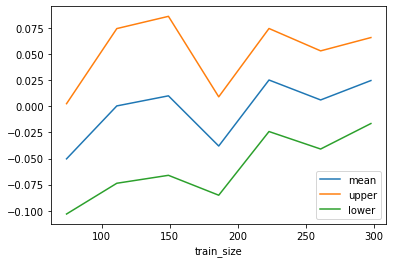

In [11]:
tr = df_stats_saved.groupby("train_size").agg([np.mean, np.std])
tr = tr['delta_MSE_%'].reset_index()
tr['upper'] = tr['mean'] + tr['std']
tr['lower'] = tr['mean'] - tr['std']
tr.plot(x="train_size", y=['mean', 'upper', 'lower'], kind='line')

## II-2- Plot Audrey's results

In [ ]:
# 'sachs' 987
# 'red_wine' 1627
records_me = all_records
data_name_me = 'red_wine'
_records_me = records_me[data_name_me]
_records_me = _records_me[(_records_me['sacred_run_id']>=1627)]

In [ ]:
from itertools import cycle

METHOD_LABELS = {
    'base_xgb': 'Baseline',
    'proposed': 'Proposed'
}

XLABEL = 'Train data size'
YLABEL = 'MSE'

plt.rc('font', **{
    'family': 'Times New Roman',
    'weight' : 'normal',
    'size'   : 16})

monochrome = False

printmd(f'# {data_name_me}')

fig, ax = plt.subplots(figsize=(8,6))
if monochrome:
    colors = cycle(['k'])
else:
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyles = cycle(['--', '-', '-.', ':'])
markers = cycle(['o', '*', '^', 's', 'X'])

plot_df = (_records_me
    .groupby(['method', 'train_size'])
    .ply_select(average = X.XGB_MSE.mean(), err_min = X.XGB_MSE.mean()-X.XGB_MSE.sem(ddof=0), err_max = X.XGB_MSE.mean()+X.XGB_MSE.sem(ddof=0))
    .reset_index()
)

for ((_method), _df), color, linestyle, marker in zip(plot_df.groupby(['method']), colors, linestyles, markers):
    kind = 'line'
    ax = plt.gca()
    markersize = 8 if marker not in ['*'] else 10
    _df.plot('train_size', 'average', kind=kind, ax=ax, label=METHOD_LABELS[_method],
                c=color, marker=marker, linestyle=linestyle, markersize=markersize)
    ax.fill_between(_df['train_size'], _df['err_min'], _df['err_max'], alpha=0.2, facecolor=color)
    plt.xlabel(XLABEL)
    plt.ylabel(YLABEL)
plt.legend()

#plt.savefig(FIG_OUT_DIR / f'{data_name_me}{"_mono" if monochrome else ""}.pdf')
plt.show()
plt.clf()

# III- Data exploration

## III-1- Sachs

In [ ]:
# Load data
sachs_df = pd.read_csv('../suite/data/sachs/data_concat.raw.txt', sep='\t')
sachs_df.describe()

## III-2- Red Wine data

In [ ]:
red_wine_df = pd.read_csv('../suite/data/wine_quality/winequality-red.csv', sep=';')
red_wine_df.describe()